# Motif identification in STUMPY

Idea is to create little pipeline to identify patterns(motifs), pick the top ones and evaluate them by profitability(or some other condition). 

* load/resample data
* apply differencing
* calculate motifs with length N
* evaluate most prominent motifs (either backtest with certain SL/TP or timebased exit or some other condition)

## Load ohlcv dataframe

This part just loads ohlcv_df dataframe from local cache. Replace by your ohlcv dataframe.


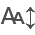

/Users/davidbrazda/Library/Application Support/v2realbot
trades_df-BAC-2024-01-01T09_30_00-2024-05-14T16_00_00-CO4B7VPWUZF-100.parquet
trades_df-BAC-2024-01-11T09:30:00-2024-01-12T16:00:00.parquet
trades_df-SPY-2024-01-01T09:30:00-2024-05-14T16:00:00.parquet
trades_df-BAC-2023-01-01T09_30_00-2024-05-25T16_00_00-47BCFOPUVWZ-100.parquet
ohlcv_df-BAC-2024-01-11T09:30:00-2024-01-12T16:00:00.parquet
trades_df-BAC-2024-05-15T09_30_00-2024-05-25T16_00_00-47BCFOPUVWZ-100.parquet
ohlcv_df-BAC-2024-01-01T09_30_00-2024-05-25T16_00_00-47BCFOPUVWZ-100.parquet
ohlcv_df-SPY-2024-01-01T09:30:00-2024-05-14T16:00:00.parquet
ohlcv_df-BAC-2024-01-01T09_30_00-2024-05-14T16_00_00-CO4B7VPWUZF-100.parquet
ohlcv_df-BAC-2023-01-01T09_30_00-2024-05-25T16_00_00-47BCFOPUVWZ-100.parquet
ohlcv_df-BAC-2023-01-01T09_30_00-2024-05-25T15_30_00-47BCFOPUVWZ-100.parquet


In [2]:
import pandas as pd
import numpy as np
from itables import init_notebook_mode, show
import datetime
from itertools import product
from appdirs import user_data_dir
import os

init_notebook_mode(all_interactive=True)

#LOAD FROM PARQUET
DATA_DIR = user_data_dir("v2realbot", False)
dir = DATA_DIR + "/notebooks/" #my local cache dir
print(DATA_DIR)
files = [f for f in os.listdir(dir) if f.endswith(".parquet")]
print('\n'.join(map(str, files)))
file_name = "ohlcv_df-BAC-2023-01-01T09_30_00-2024-05-25T15_30_00-47BCFOPUVWZ-100.parquet"
ohlcv_df = pd.read_parquet(dir+file_name,engine='pyarrow')
#filter ohlcv_df to certain date range (assuming datetime index)
ohlcv_df = ohlcv_df.loc["2024-02-12 9:30":"2024-02-18 16:00"]


### Resampling
This is resampling of 1s data above to lower resolution if necessary.

In [3]:
#resample settings for custom columns
from vectorbtpro.utils.config import merge_dicts, Config, HybridConfig
from vectorbtpro import _typing as tp
from vectorbtpro.generic import nb as generic_nb

_feature_config: tp.ClassVar[Config] = HybridConfig(
    {
        "buyvolume": dict(
            resample_func=lambda self, obj, resampler: obj.vbt.resample_apply(
                resampler,
                generic_nb.sum_reduce_nb,
            )
        ),
        "sellvolume": dict(
            resample_func=lambda self, obj, resampler: obj.vbt.resample_apply(
                resampler,
                generic_nb.sum_reduce_nb,
            )
        ),
        "trades": dict(
            resample_func=lambda self, obj, resampler: obj.vbt.resample_apply(
                resampler,
                generic_nb.sum_reduce_nb,
            )
        )
    }
)

In [4]:
#resampling to lower res
import vectorbtpro as vbt
from v2realbot.utils.utils import zoneNY
vbt.settings.set_theme("dark")
vbt.settings['plotting']['layout']['width'] = 1280
vbt.settings.plotting.auto_rangebreaks = True
basic_data = vbt.Data.from_data(vbt.symbol_dict({"BAC": ohlcv_df}), tz_convert=zoneNY)

basic_data._feature_config = _feature_config

sec_data = basic_data.data["BAC"]

t1data = basic_data[['open', 'high', 'low', 'close', 'volume','vwap','trades']].resample("1T")
t1data = t1data.transform(lambda df: df.between_time('09:30', '16:00').dropna())


m30data  = basic_data[['open', 'high', 'low', 'close', 'volume','vwap','trades']].resample("30T")
m30data = m30data.transform(lambda df: df.between_time('09:30', '16:00').dropna())
#m30data.data["BAC"].info()


None
Loaded env variables from file None


Activating profile profile1

In [5]:
import stumpy
# The length of the motif
m = 20

#lets use 1min data first
#apply differencing, either absolute .diff() or relative .pct_change() to make data stationary
#first value becomes na - drop it
timeseries_sr = t1data.get('vwap').diff().dropna()

#for stationary data, we can use just stump
matrix_profile = stumpy.stump(timeseries_sr.values.T, m)

#timeseries_sr
     

Result is NumPy array with 4 columns:
- `Matrix Profile` - distance between each subsequence and nearest neighbor.
- `Matrix Profile Index`- the index of the nearest neighbor for each subsequence, indicating where the closest match to the subsequence occurs in the time series.
- `Left Matrix Profile Index` - the nearest neighbor when looking for matches to the left (earlier in the time series). Useful when analyzing directional dependencies or patterns in time series.
- `Right Matrix Profile Index` - the index of the nearest neighbor when looking for matches to the right (later in the time series).

Then we use motifs method to get 4 most promiment motifs and 5 closest neihbors for each 

TBD explore anomanly detection (#discord_distances, discord_indices = discords(time_series, mp[:, 0], k=3))

In [6]:
from stumpy import motifs

#get 4 most prominent motifs
motif_distances, motif_indices = motifs(timeseries_sr, matrix_profile[:, 0], max_motifs=4, min_neighbors=5)

#motif_distances
#motif_indices

The we can visualize these first as Overlay and then on the whole timeseries.

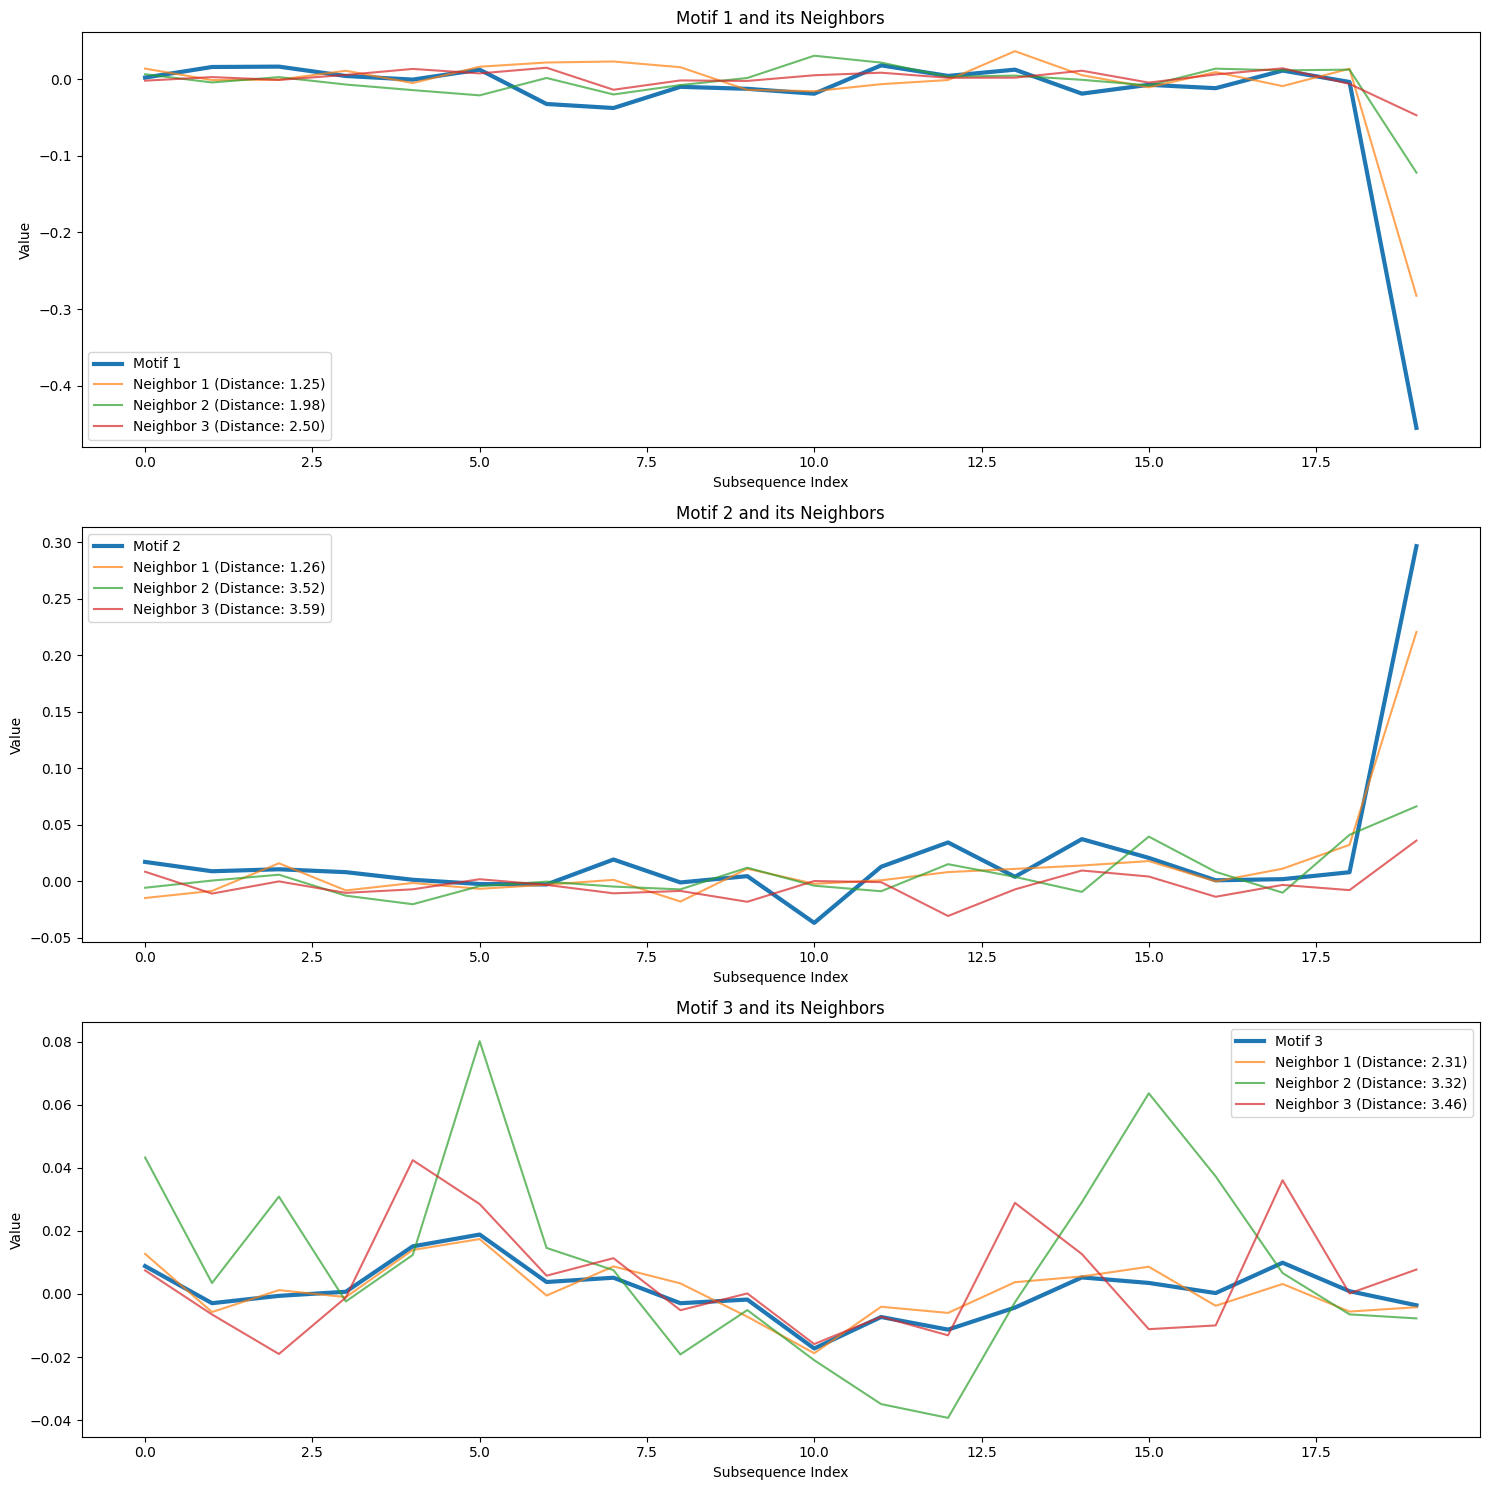

In [40]:
#as overlay
from stumpy import motifs, match
import matplotlib.pyplot as plt
%matplotlib inline

def visualize_motifs(time_series, motif_distances, motif_indices, subsequence_length, max_neighbors=5):
    n_motifs = len(motif_indices)
    fig, axs = plt.subplots(n_motifs, 1, figsize=(15, 5*n_motifs), sharex=False)
    if n_motifs == 1:
        axs = [axs]
    
    for i, (motif_idxs, distances, ax) in enumerate(zip(motif_indices, motif_distances, axs)):
        # Extract the first index if motif_idxs is an array or list
        main_motif_idx = motif_idxs[0] if isinstance(motif_idxs, (list, np.ndarray)) else motif_idxs
        
        # Extract the motif sequence
        motif = time_series[main_motif_idx:main_motif_idx+subsequence_length]
        
        # Plot the main motif
        ax.plot(range(subsequence_length), motif, label=f'Motif {i+1}', linewidth=3)
        
        # Plot neighbors
        for j, (neighbor_idx, dist) in enumerate(zip(motif_idxs[1:], distances[1:])):
            if j >= max_neighbors:
                break
            neighbor = time_series[neighbor_idx:neighbor_idx+subsequence_length]
            similarity = 1 - dist  # Convert distance to similarity
            ax.plot(range(subsequence_length), neighbor, 
                    label=f'Neighbor {j+1} (Distance: {dist:.2f})', 
                    alpha=0.7)
        
        ax.set_title(f'Motif {i+1} and its Neighbors')
        ax.legend()
        ax.set_xlabel('Subsequence Index')
        ax.set_ylabel('Value')
    
    plt.tight_layout()
    plt.show()

visualize_motifs(time_series=timeseries_sr, motif_distances=motif_distances, motif_indices=motif_indices, subsequence_length=m)


In [8]:
timeseries_sr.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 1949 entries, 2024-02-12 09:31:00-05:00 to 2024-02-16 15:59:00-05:00
Series name: vwap
Non-Null Count  Dtype  
--------------  -----  
1949 non-null   float64
dtypes: float64(1)
memory usage: 30.5 KB


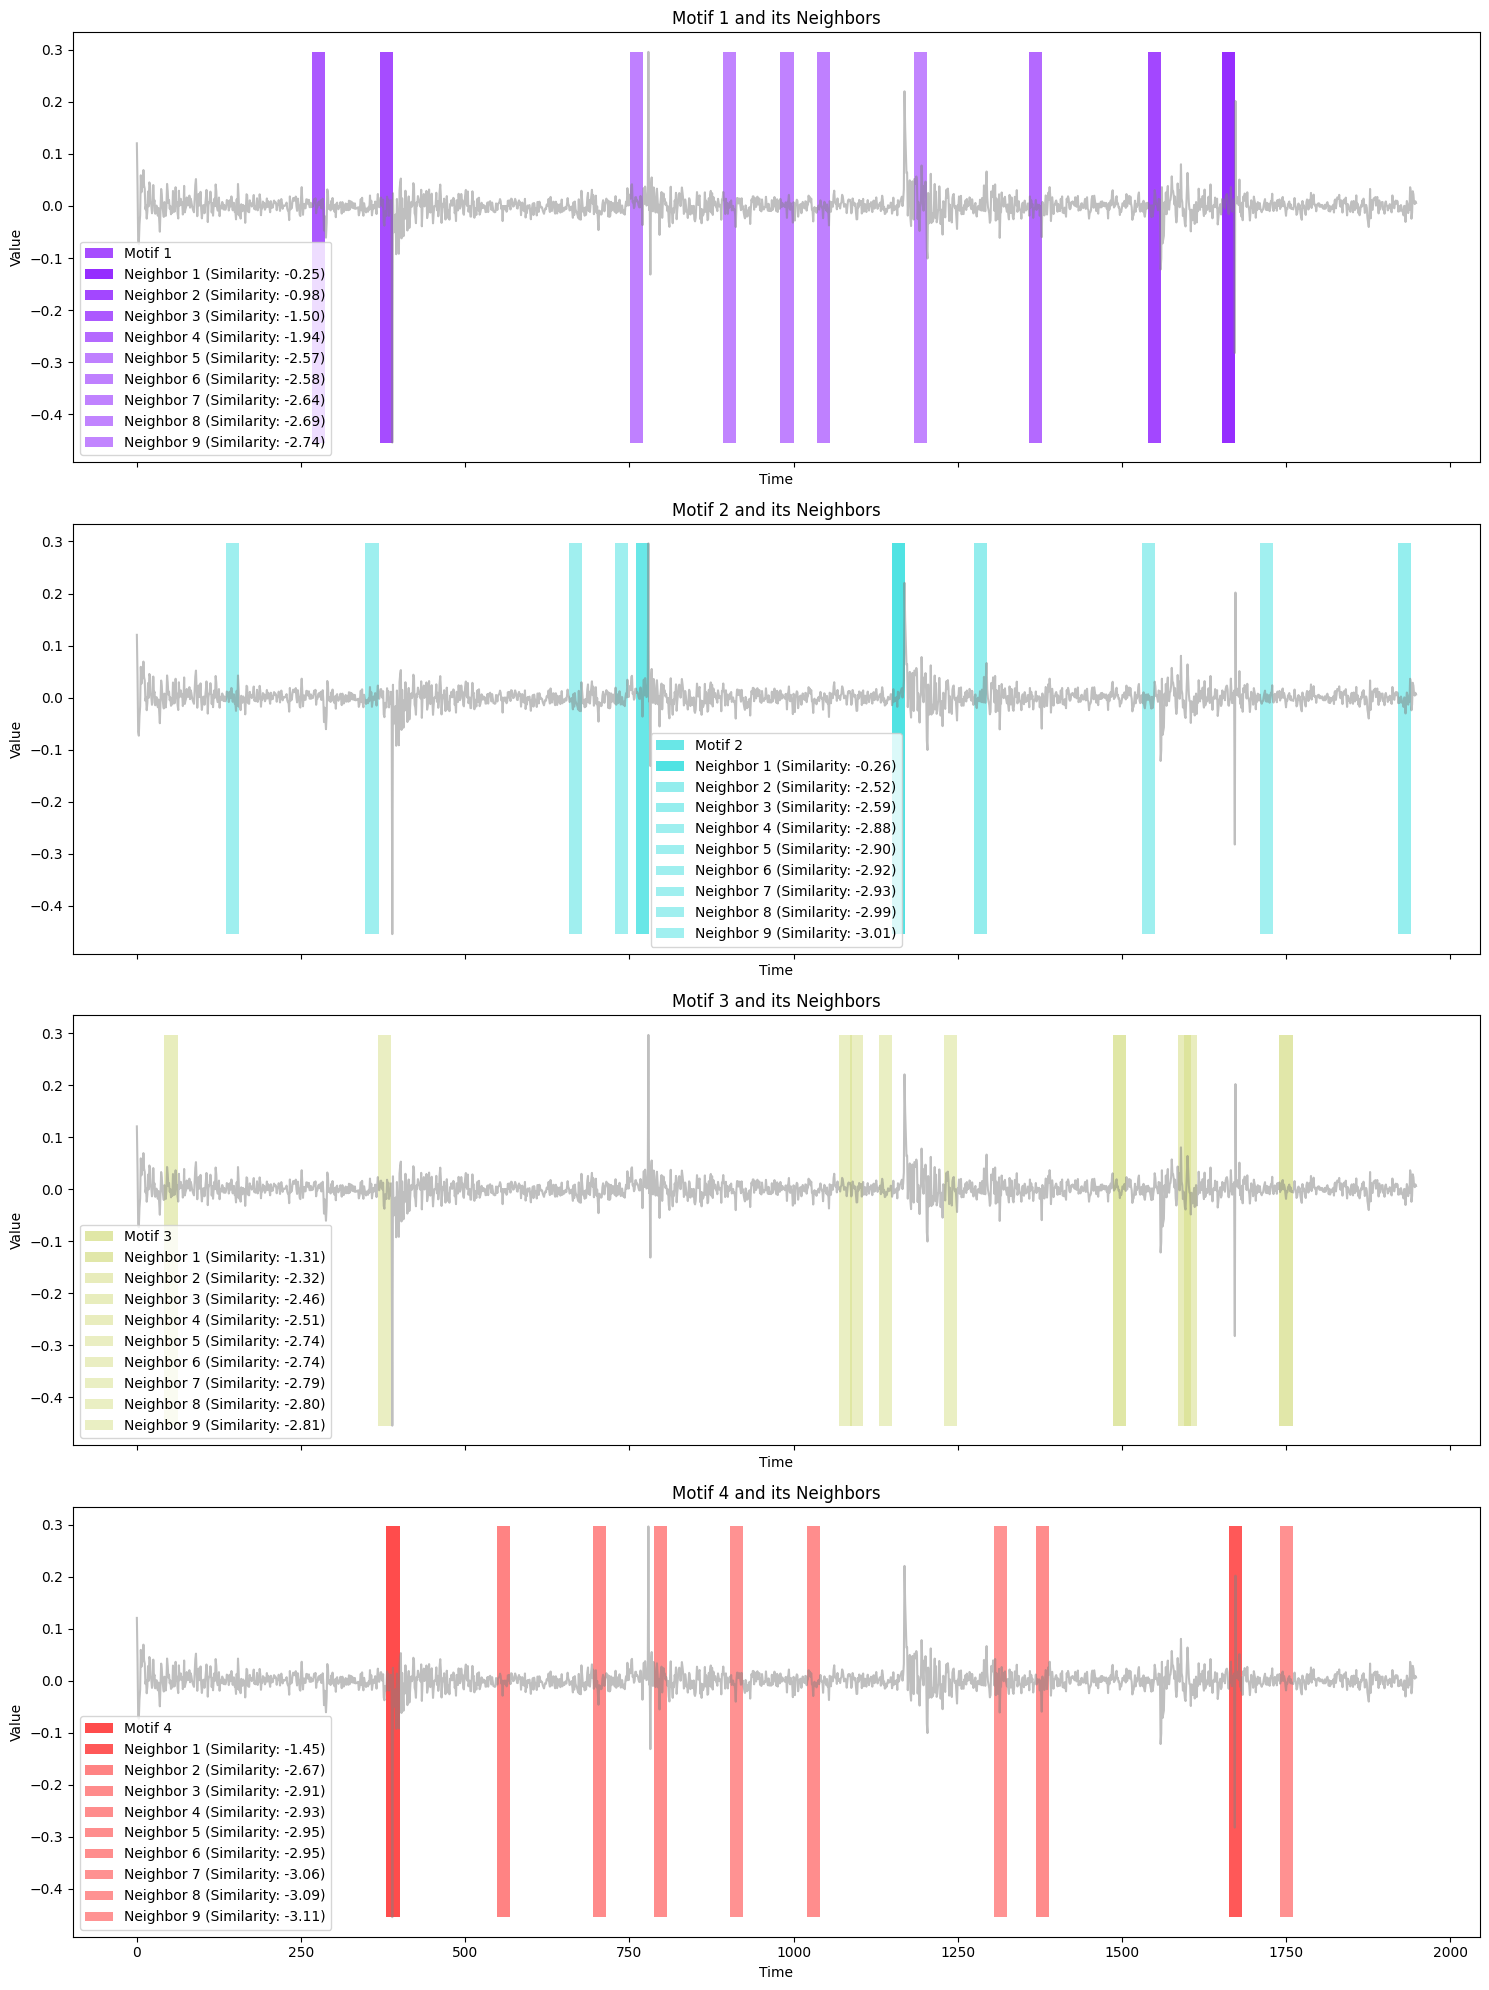

In [9]:
#Visualize on the whole timeseries
import numpy as np
from matplotlib.patches import Rectangle
import matplotlib.colors as mcolors

def visualize_motifs_on_timeseries(time_series, motif_distances, motif_indices, subsequence_length):
    n_motifs = len(motif_indices)
    fig, axs = plt.subplots(n_motifs, 1, figsize=(15, 5*n_motifs), sharex=True)
    if n_motifs == 1:
        axs = [axs]
    
    # Define a color for each motif
    colors = plt.cm.rainbow(np.linspace(0, 1, n_motifs))
    
    for i, (motif_idxs, distances, ax, color) in enumerate(zip(motif_indices, motif_distances, axs, colors)):
        # Plot the entire time series
        ax.plot(time_series.values, color='gray', alpha=0.5)
        
        # Extract the main motif index
        main_motif_idx = motif_idxs[0] if isinstance(motif_idxs, (list, np.ndarray)) else motif_idxs
        
        # Plot the main motif as a rectangle
        rect = Rectangle((main_motif_idx, min(time_series)), subsequence_length, max(time_series) - min(time_series),
                         facecolor=color, alpha=0.7, label=f'Motif {i+1}')
        ax.add_patch(rect)
        
        # Plot neighbors
        nb = 0
        for neighbor_idx, dist in zip(motif_idxs[1:], distances[1:]):
            nb += 1
            similarity = 1 - dist  # Convert distance to similarity
            # Use similarity to determine the alpha of the color 1 - (0.7 / 5) * x
            neighbor_color = mcolors.to_rgba(color, alpha=1 - (0.7 / 5) * dist)
            rect = Rectangle((neighbor_idx, min(time_series)), subsequence_length, max(time_series) - min(time_series),
                             facecolor=neighbor_color, label=f'Neighbor {nb} (Similarity: {similarity:.2f})')
            ax.add_patch(rect)

        # # Adjust the limits of the plot so the rectangle is visible
        # ax.set_xlim(0, len(time_series))
        # ax.set_ylim(min(time_series) - 10, max(time_series) + 10)

        ax.set_title(f'Motif {i+1} and its Neighbors')
        ax.legend()
        ax.set_xlabel('Time')
        ax.set_ylabel('Value')
        ax.autoscale()
    
    plt.tight_layout()
    plt.show()

visualize_motifs_on_timeseries(timeseries_sr, motif_distances, motif_indices, m)

## Unanchored chain

Unanchored chains could be used for trending data.

In [10]:
timeseries_sr_trending = t1data.get('vwap')
matrix_profile_tr = stumpy.stump(timeseries_sr_trending, m)

#for trend data we can use 
all_chain_set, unanchored_chain = stumpy.allc(matrix_profile_tr[:, 2], matrix_profile_tr[:, 3])

In [11]:
#Charting with lightweight-chart for better interactivity

#!pip install git+https://github.com/drew2323/lightweight-charts-python.git
from lightweight_charts import JupyterChart, chart, Panel

motifs = []
for i in range(unanchored_chain.shape[0]):
    new_df = timeseries_sr_trending.iloc[unanchored_chain[i]:unanchored_chain[i]+m]
    motifs.append((new_df.to_frame(name=f"Motif {i+1}"), f"Motif {i+1}"))

pane1 = Panel(
    right = [(timeseries_sr_trending.to_frame(name="Time series main"),"Time series main")]+motifs
)

ch = chart([pane1], sync=False, size="s", session=None)

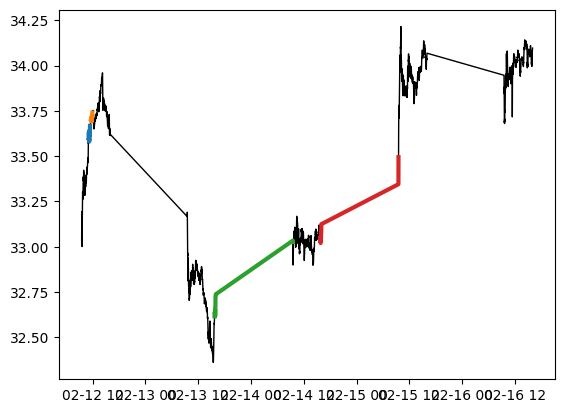

In [12]:
#Standard charting

import itertools

plt.plot(timeseries_sr_trending, linewidth=1, color='black')
for i in range(unanchored_chain.shape[0]):
    y = timeseries_sr_trending.iloc[unanchored_chain[i]:unanchored_chain[i]+m]
    x = y.index.values
    plt.plot(x, y, linewidth=3)
# color = itertools.cycle(['white', 'gainsboro'])
# for i, x in enumerate(range(0, ohlcv_df.shape[0], 52)):
#     plt.text(x+12, 0.9, str(2004+i), color="black", fontsize=20)
#     rect = Rectangle((x, -1), 52, 2.5, facecolor=next(color))
#     plt.gca().add_patch(rect)

plt.show()

### another approach for visualization of 1D motifs

In [13]:
matrix_profile = stumpy.stump(timeseries_sr, m)

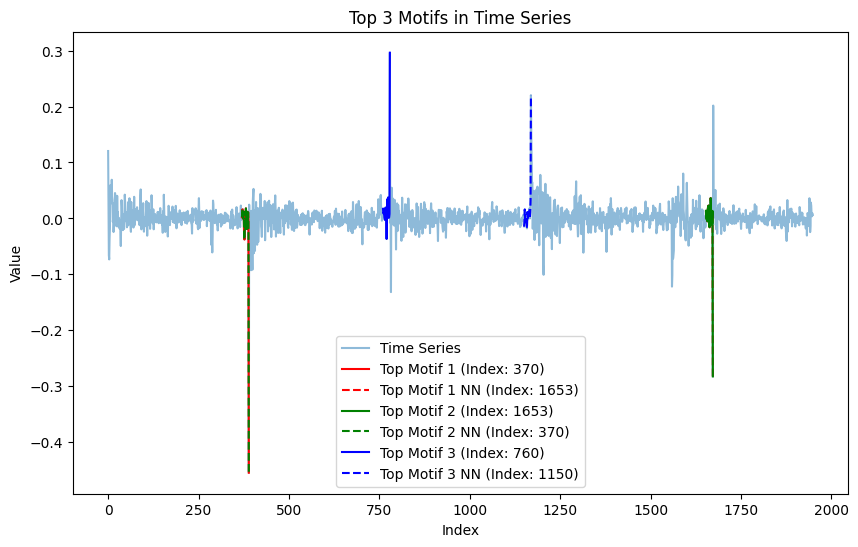

In [14]:

# Extract the matrix profile values (first column) and the corresponding index (second column)
mp = matrix_profile[:, 0]
mpi = matrix_profile[:, 1]

# Sort matrix profile to get indices of top motifs
sorted_indices = np.argsort(mp)

# Top motifs: first, second, and third
top_1_idx = sorted_indices[0]
top_2_idx = sorted_indices[1]
top_3_idx = sorted_indices[2]

# Get the nearest neighbor indices for the top motifs
top_1_nn_idx = mpi[top_1_idx]
top_2_nn_idx = mpi[top_2_idx]
top_3_nn_idx = mpi[top_3_idx]

# Plot the time series
plt.figure(figsize=(10, 6))
plt.plot(timeseries_sr.values, label="Time Series", alpha=0.5)

# Highlight the motifs with different colors
plt.plot(range(top_1_idx, top_1_idx + m), timeseries_sr[top_1_idx:top_1_idx + m], color='red', label=f'Top Motif 1 (Index: {top_1_idx})')
plt.plot(range(top_1_nn_idx, top_1_nn_idx + m), timeseries_sr[top_1_nn_idx:top_1_nn_idx + m], color='red', linestyle='dashed', label=f'Top Motif 1 NN (Index: {top_1_nn_idx})')

plt.plot(range(top_2_idx, top_2_idx + m), timeseries_sr[top_2_idx:top_2_idx + m], color='green', label=f'Top Motif 2 (Index: {top_2_idx})')
plt.plot(range(top_2_nn_idx, top_2_nn_idx + m), timeseries_sr[top_2_nn_idx:top_2_nn_idx + m], color='green', linestyle='dashed', label=f'Top Motif 2 NN (Index: {top_2_nn_idx})')

plt.plot(range(top_3_idx, top_3_idx + m), timeseries_sr[top_3_idx:top_3_idx + m], color='blue', label=f'Top Motif 3 (Index: {top_3_idx})')
plt.plot(range(top_3_nn_idx, top_3_nn_idx + m), timeseries_sr[top_3_nn_idx:top_3_nn_idx + m], color='blue', linestyle='dashed', label=f'Top Motif 3 NN (Index: {top_3_nn_idx})')

# Add title and labels
plt.title('Top 3 Motifs in Time Series')
plt.xlabel('Index')
plt.ylabel('Value')

# Display legend
plt.legend()

# Show plot
plt.show()

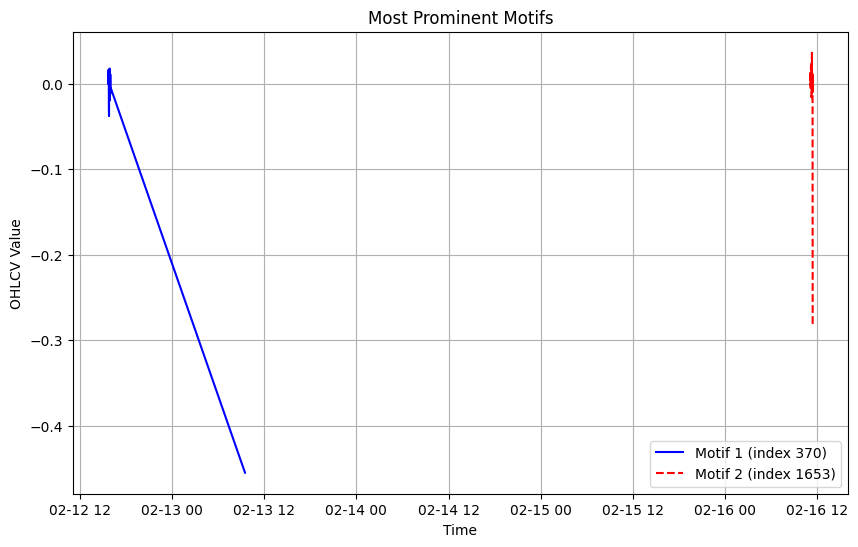

In [15]:

# Extract the matrix profile values (first column) and the corresponding index (second column)
profile_values = matrix_profile[:, 0]
motif_indices = matrix_profile[:, 1]

# Find the index of the most prominent motif (the smallest value in the matrix profile)
motif_1_index = np.argmin(profile_values)
motif_2_index = motif_indices[motif_1_index]

# Extract the actual subsequences from the OHLCV data
motif_1 = timeseries_sr[motif_1_index:motif_1_index + m]
motif_2 = timeseries_sr[motif_2_index:motif_2_index + m]

# Plot the motifs side by side for comparison
plt.figure(figsize=(10, 6))
plt.plot(motif_1, label=f'Motif 1 (index {motif_1_index})', color='blue')
plt.plot(motif_2, label=f'Motif 2 (index {motif_2_index})', color='red', linestyle='--')
plt.title('Most Prominent Motifs')
plt.xlabel('Time')
plt.ylabel('OHLCV Value')
plt.legend()
plt.grid(True)
plt.show()


## Multivariate

In [16]:
labels = ["open","close","vwap", "trades", "volume"]
mp_m, indices = stumpy.mstump(t1data.get(labels), m)

In [17]:
import plotly.graph_objects as go

# Create a figure
fig = go.Figure()

# Add traces for each time series component in OHLCV
for i, label in enumerate(labels):
    fig.add_trace(go.Scatter(
        y=mp_m[i],
        mode='lines',
        name=f'{label} Matrix Profile'
    ))

# Update layout
fig.update_layout(
    title="Multivariate Matrix Profile for OHLCV Data",
    xaxis_title="Time Index",
    yaxis_title="Matrix Profile",
    hovermode="x unified"
)

# Show the figure
fig.show()


# Univariate and simple backtesting (returns)

- Load a sample time series dataset.
- Discover motifs using STUMPY's stump and motifs functions.
- Create a DataFrame containing motif indices and their associated returns over a 10-bar horizon.
- Identify the most profitable motif category.

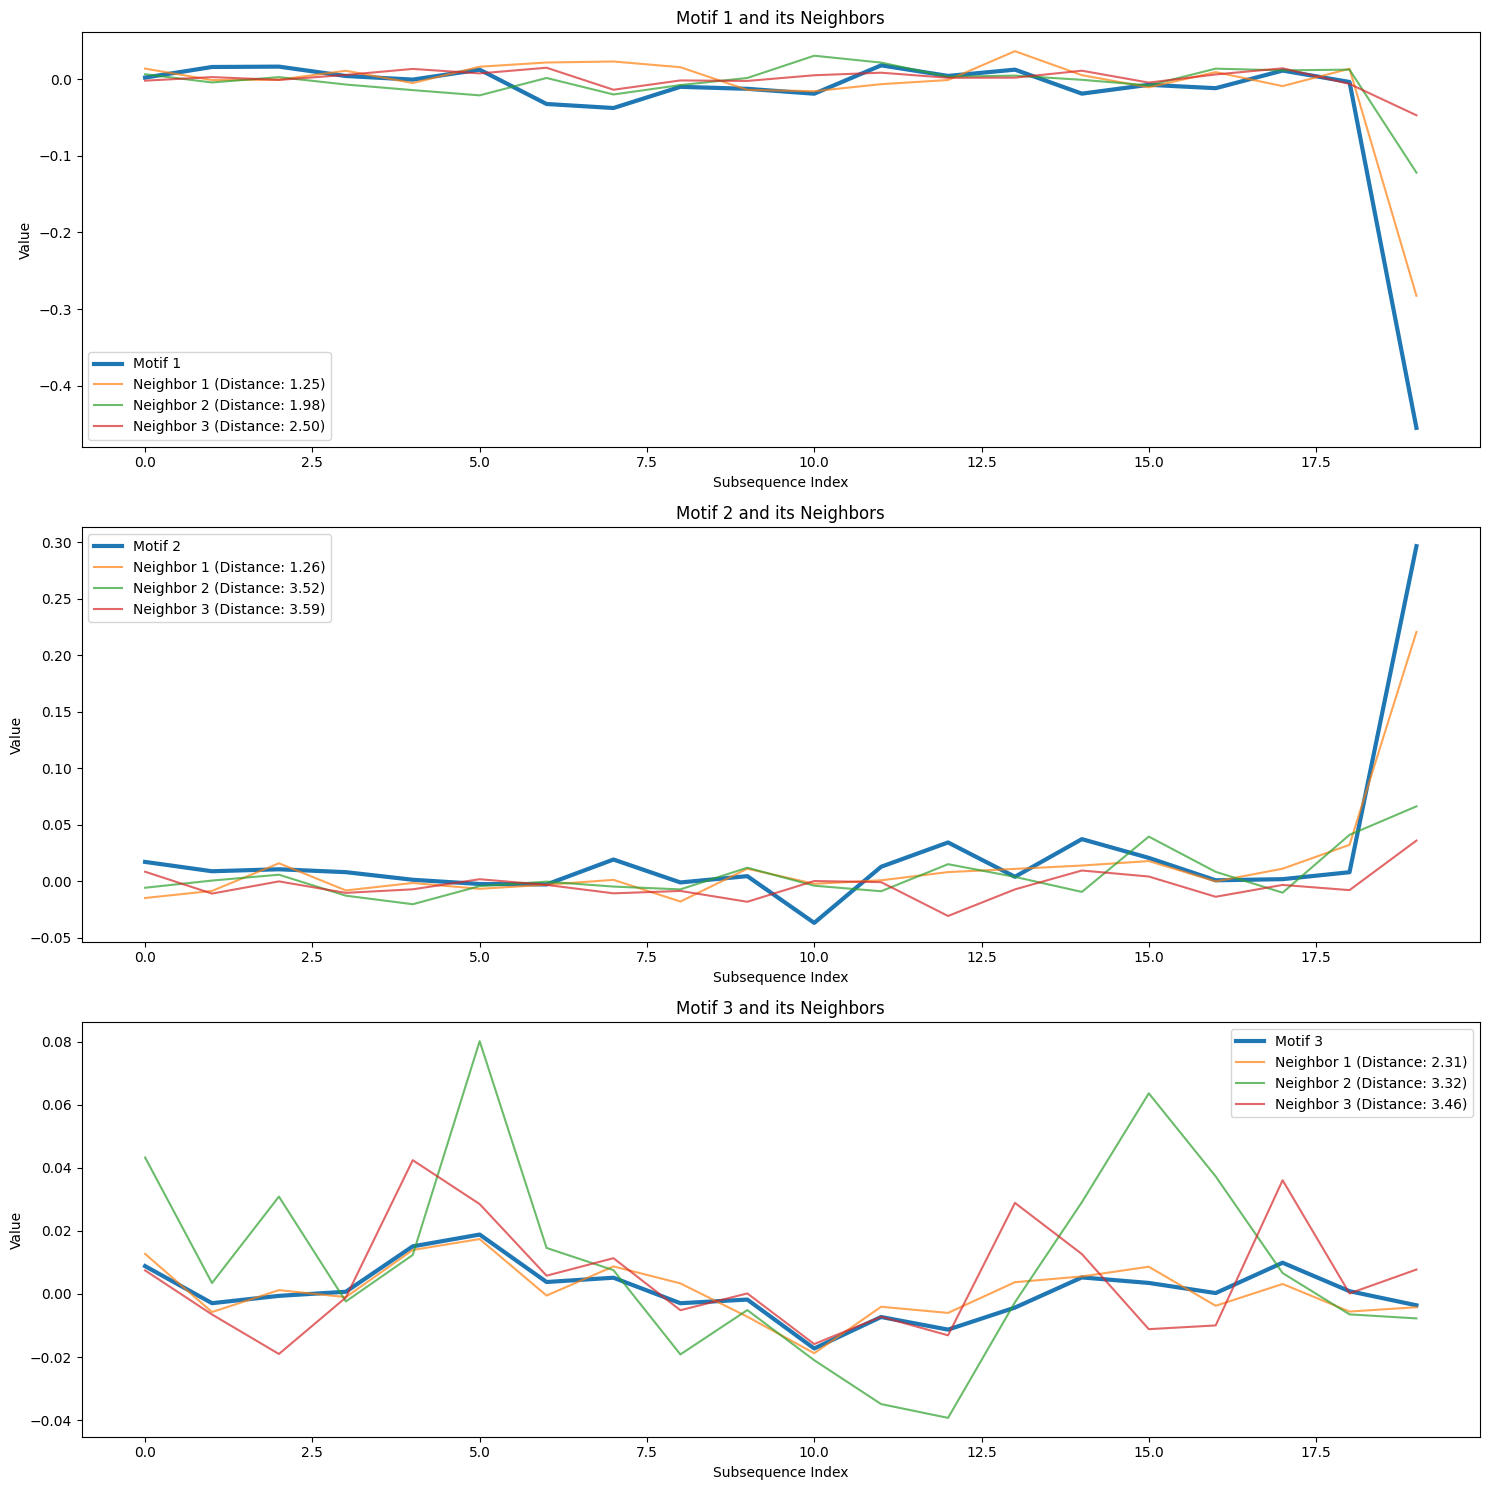

Motif DataFrame with profits:
     motif_id  match_id  distance  start_idx  end_idx  profit_long  \
0          0         0  0.000000        370      390     0.206577   
1          0         1  1.250590       1653     1673    -0.967765   
2          0         2  1.982121       1540     1560    -1.380473   
3          0         3  2.503828        266      286    -1.502156   
4          1         0  0.000000        760      780     0.654485   
5          1         1  1.261131       1150     1170    -0.805488   
6          1         2  3.515795       1275     1295    -0.167817   
7          1         3  3.590752       1920     1940          NaN   
8          2         0  0.000000       1487     1507    -1.861615   
9          2         1  2.309025       1740     1760     0.009996   
10         2         2  3.323742       1585     1605    -0.992155   
11         2         3  3.456676         42       62    -3.815360   

    profit_short  
0       2.206577  
1       1.032235  
2       0.6195

In [41]:
import numpy as np
import pandas as pd
import stumpy


# Convert the 'close' column to a 1D NumPy array
T = timeseries_sr.values

# Parameters
N = 20  # Window length (motif length)
max_motifs = 3  # Number of main motifs to discover
motifs_per_category = 4  # Number of similar motifs to extract per main motif
future_horizon = 10  # Number of bars to measure future returns

# Step 1: Calculate the Matrix Profile
matrix_profile = stumpy.stump(timeseries_sr, m=N)

# Step 2: Discover the motifs return distances and indices in the shape of (max_motifs, motifs_per_category)
motif_distances, motif_indices = stumpy.motifs(timeseries_sr, matrix_profile[:, 0], max_motifs=max_motifs, max_matches=motifs_per_category)

# Create a DataFrame to store the motifs information
motif_results = []

# Since motif_indices is an array of shape (3, 4), iterate accordingly
for motif_id in range(motif_indices.shape[0]):  # Iterate over each row, i.e., each motif
    for match_id in range(motif_indices.shape[1]):  # Iterate over each column, i.e., each match
        start_idx = motif_indices[motif_id, match_id]
        distance = motif_distances[motif_id, match_id]

        # Check if the entry is valid (not NaN)
        if np.isnan(start_idx):
            continue
        
        # Convert to integer for indexing
        start_idx = int(start_idx)
        end_idx = start_idx + N
        
        # Check if there's enough data beyond the end index to calculate future returns
        if end_idx + future_horizon < len(timeseries_sr):
            # Calculate the profit/loss over the next 10 bars from the end of the motif
            future_return_long = (timeseries_sr.iloc[end_idx + future_horizon] - timeseries_sr.iloc[end_idx]) / timeseries_sr.iloc[end_idx]
            future_return_short = (timeseries_sr.iloc[end_idx + future_horizon] + timeseries_sr.iloc[end_idx]) / timeseries_sr.iloc[end_idx]
        else:
            future_return_long = np.nan  # Not enough future data available
            future_return_short = np.nan
        
        # Append the motif result
        motif_results.append({
            'motif_id': motif_id,          # Identifies the motif category within the set
            'match_id': match_id,         # Rank/order of the match within the motif category
            'distance': distance,
            'start_idx': start_idx,
            'end_idx': end_idx,
            'profit_long': future_return_long,
            'profit_short': future_return_short
        })

# Convert the results into a DataFrame
motif_df = pd.DataFrame(motif_results)

# Step 3: Calculate the average profit for each motif category
motif_profits_long = motif_df.groupby('motif_id')['profit_long'].mean().reset_index()
most_profitable_motif_id_long = motif_profits_long.sort_values(by='profit_long', ascending=False).iloc[0]['motif_id']

motif_profits_sum_long = motif_df.groupby('motif_id')['profit_long'].sum().reset_index()
most_profitable_motif_sum_id_long = motif_profits_sum_long.sort_values(by='profit_long', ascending=False).iloc[0]['motif_id']

motif_profits_short = motif_df.groupby('motif_id')['profit_short'].mean().reset_index()
most_profitable_motif_id_short = motif_profits_short.sort_values(by='profit_short', ascending=False).iloc[0]['motif_id']

motif_profits_sum_short = motif_df.groupby('motif_id')['profit_short'].sum().reset_index()
most_profitable_motif_sum_id_short = motif_profits_sum_short.sort_values(by='profit_short', ascending=False).iloc[0]['motif_id']

visualize_motifs(time_series=timeseries_sr, motif_distances=motif_distances, motif_indices=motif_indices, subsequence_length=m)

# Display results
print("Motif DataFrame with profits:\n", motif_df)
print("\nAverage profit long per motif category:\n", motif_profits_long)
print(f"\nThe most profitable long motif avg category is: {most_profitable_motif_id_long}")
print("\Sum profit long per motif category:\n", motif_profits_sum_long)
print(f"\nThe most profitable long motif sum category is: {most_profitable_motif_sum_id_long}")

print("\nAverage profit short per motif category:\n", motif_profits_short)
print(f"\nThe most profitable short motif avg category is: {most_profitable_motif_id_short}")
print("\Sum profit short per motif category:\n", motif_profits_sum_short)
print(f"\nThe most profitable short motif sum category is: {most_profitable_motif_sum_id_short}")